In [246]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from u_net.UNet import UNet
from torch.autograd import Variable

In [247]:
def open_image(path):
    img = Image.open(path)
    img = img.convert("RGB")
    img = np.array(img)
    return img

def gen_mask(Re):
    # generate mask with the boundary conditions and RE encoded into the image
    mask = np.zeros((128, 128, 3), dtype=np.uint8)
    # mask is the Re number where min is 0 and max is 4000 scaled to 0-255
    encoded_RE_color = (int(Re / 4000 * 255), 255, 0)
    mask[:, :, :] = encoded_RE_color
    # walls on the left, right and bottom
    border_color = (255, 255, 255)
    mask[-1, :, :] = border_color # bottom
    mask[:, 0, :] = border_color # left
    mask[:, -1, :] = border_color # right
    return mask

def generate_input(Re, ts, mode='mask'):
    if mode == 'mask':
        img = gen_mask(Re)
    elif mode == 'u':
        img = open_image(f"data/{Re:.1f}/u_{ts:.2f}.png")
    elif mode == 'v':
        img = open_image(f"data/{Re:.1f}/v_{ts:.2f}.png")
    img = img.transpose(2, 0, 1)
    return img

def generate_output(Re, mode='mask'):
    if mode == 'mask':
        img = open_image(f"data/{Re}/p_ss.png")
    elif mode == 'u':
        img = open_image(f"data/{Re}/u_ss.png")
    elif mode == 'v':
        img = open_image(f"data/{Re}/v_ss.png")
    img = img.transpose(2, 0, 1)
    return img



In [248]:
RE = 1000.
ts = 3.45

In [249]:
img_u = generate_input(RE, ts, 'u')
img_v = generate_input(RE, ts, 'v')
img_mask = generate_input(RE, ts, 'mask')
img_u.shape, img_v.shape

((3, 128, 128), (3, 128, 128))

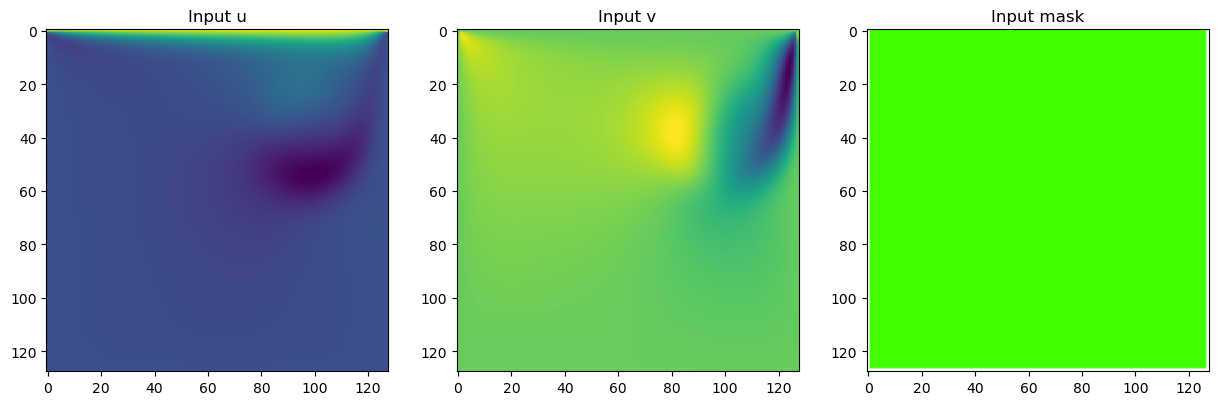

In [250]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img_u.transpose(1, 2, 0))
axes[0].set_title("Input u")
axes[1].imshow(img_v.transpose(1, 2, 0))
axes[1].set_title("Input v")
axes[2].imshow(img_mask.transpose(1, 2, 0))
axes[2].set_title("Input mask")
plt.show()

In [251]:
output_mask = generate_output(RE, 'mask')
output_u = generate_output(RE, 'u')
output_v = generate_output(RE, 'v')
output_mask.shape, output_u.shape, output_v.shape

((3, 128, 128), (3, 128, 128), (3, 128, 128))

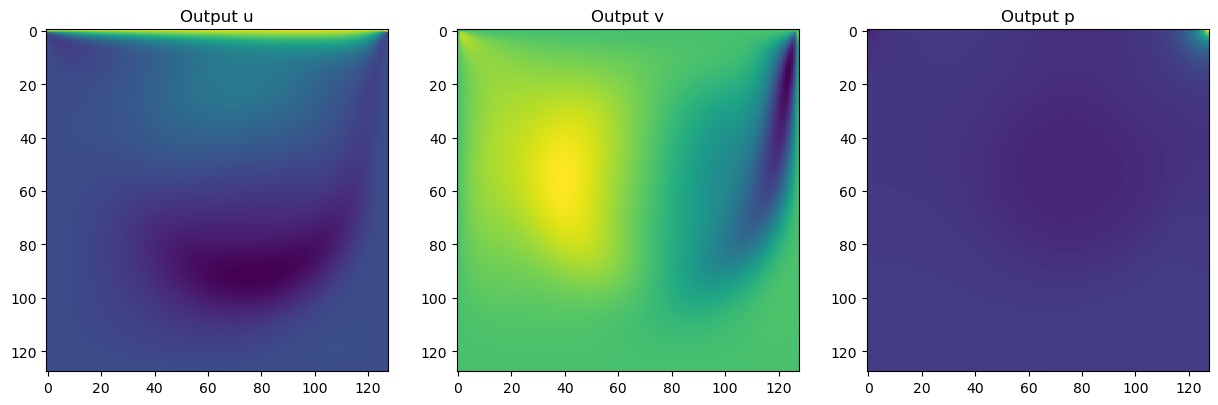

In [252]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(output_u.transpose(1, 2, 0))
axes[0].set_title("Output u")
axes[1].imshow(output_v.transpose(1, 2, 0))
axes[1].set_title("Output v")
axes[2].imshow(output_mask.transpose(1, 2, 0))
axes[2].set_title("Output p")
plt.show()

Conver to range of -1 to 1

In [253]:
# convert img values to -1 to 1
img_u = img_u / 255 * 2 - 1
img_v = img_v / 255 * 2 - 1

In [254]:
modes = ['mask', 'u', 'v']
input_images = np.array([generate_input(100., 0., mode) for mode in modes])
output_images = np.array([generate_output(100., mode) for mode in modes])
input_images.shape, output_images.shape

((3, 3, 128, 128), (3, 3, 128, 128))

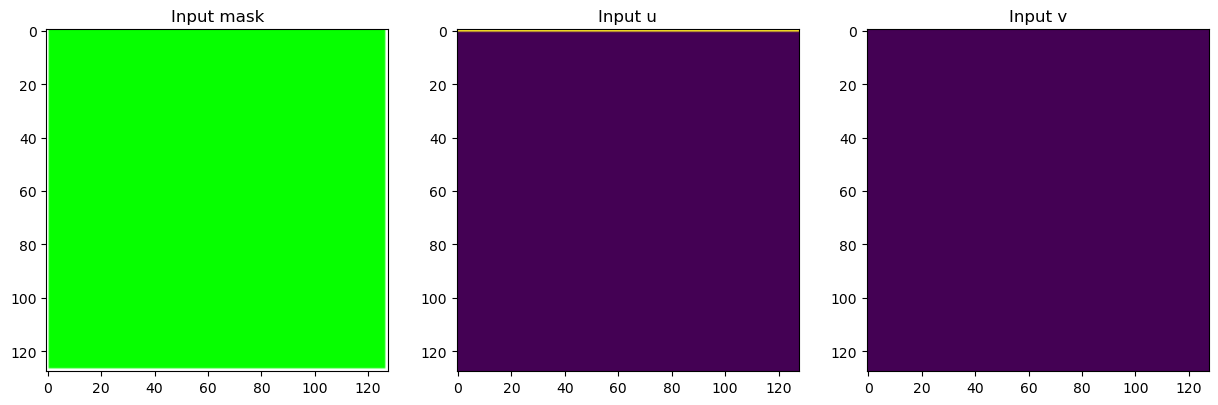

In [256]:
# plot all input images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(input_images[0].transpose(1, 2, 0))
axes[0].set_title("Input mask")
axes[1].imshow(input_images[1].transpose(1, 2, 0))
axes[1].set_title("Input u")
axes[2].imshow(input_images[2].transpose(1, 2, 0))
axes[2].set_title("Input v")
plt.show()

In [257]:
batch_size = 3
targets = Variable(torch.FloatTensor(batch_size, 3, 128, 128))
inputs  = Variable(torch.FloatTensor(batch_size, 3, 128, 128))

In [258]:
inputs.data.copy_(torch.from_numpy(input_images))
targets.data.copy_(torch.from_numpy(output_images))

tensor([[[[ 68.,  62.,  50.,  ...,  44.,  96., 253.],
          [ 67.,  59.,  51.,  ...,  44.,  75., 124.],
          [ 56.,  53.,  50.,  ...,  39.,  51.,  62.],
          ...,
          [ 39.,  39.,  39.,  ...,  39.,  39.,  39.],
          [ 39.,  39.,  39.,  ...,  39.,  39.,  39.],
          [ 39.,  39.,  39.,  ...,  39.,  39.,  39.]],

         [[  1.,  73.,  98.,  ..., 177., 201., 231.],
          [ 60.,  81.,  96.,  ..., 177., 194., 210.],
          [ 87.,  92.,  99.,  ..., 173., 182., 188.],
          ...,
          [126., 126., 126.,  ..., 126., 126., 126.],
          [126., 126., 126.,  ..., 126., 126., 126.],
          [126., 126., 126.,  ..., 126., 126., 126.]],

         [[ 84., 137., 141.,  ..., 125.,  96.,  36.],
          [132., 138., 141.,  ..., 125., 108.,  79.],
          [140., 140., 141.,  ..., 128., 121., 115.],
          ...,
          [142., 142., 142.,  ..., 142., 142., 142.],
          [142., 142., 142.,  ..., 142., 142., 142.],
          [142., 142., 142.,  ...

In [259]:
expo = 3
dropout = 0.
model = UNet(channelExponent=expo, dropout=dropout)

model.load_state_dict( torch.load('u_net/model') )

<All keys matched successfully>

In [260]:
predictions = model(inputs)
predictions = predictions.data.cpu().numpy()

In [261]:
def normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))

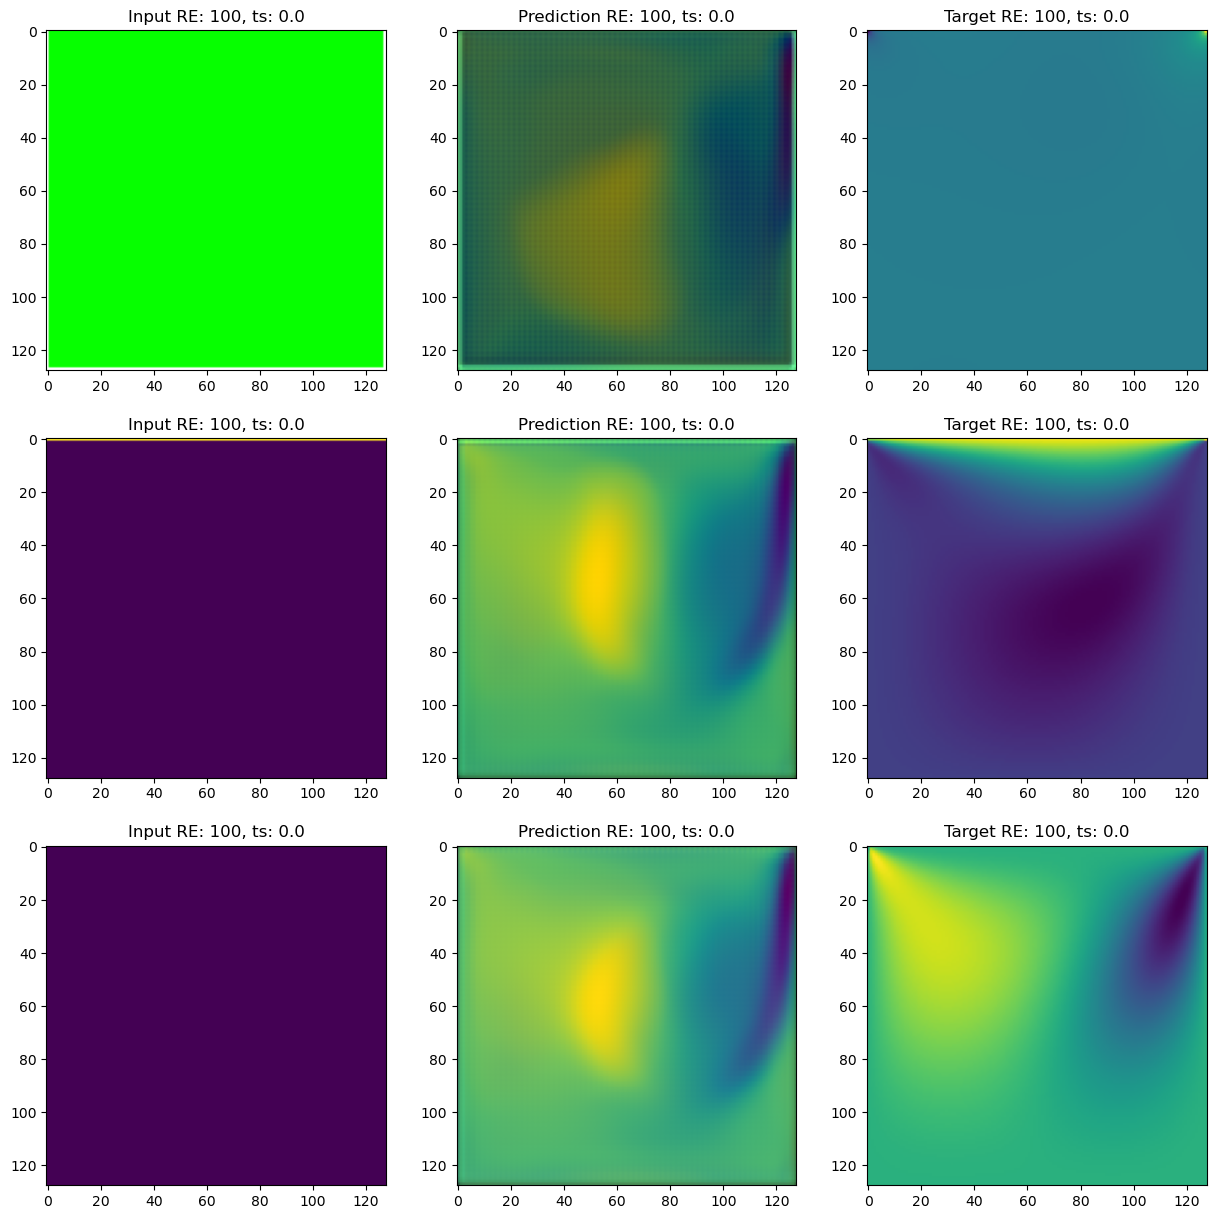

: 

In [263]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    axes[i, 0].imshow(input_images[i].transpose(1, 2, 0))
    axes[i, 0].set_title(f"Input RE: {100}, ts: {0.}")
    predictions[i] = normalize(predictions[i])
    axes[i, 1].imshow(predictions[i].transpose(1, 2, 0))
    axes[i, 1].set_title(f"Prediction RE: {100}, ts: {0.}")
    axes[i, 2].imshow(output_images[i].transpose(1, 2, 0))
    axes[i, 2].set_title(f"Target RE: {100}, ts: {0.}")
plt.show()